Dataset extracted to: /content/dataset/Training Data
Classes: ['2', '4', '6', 'Board']
Epoch 1/8 - Train Loss: 1.2770, Val Loss: 1.0377
Epoch 2/8 - Train Loss: 0.7941, Val Loss: 0.8471
Epoch 3/8 - Train Loss: 0.5425, Val Loss: 0.6875
Epoch 4/8 - Train Loss: 0.3412, Val Loss: 0.8474
Epoch 5/8 - Train Loss: 0.2044, Val Loss: 0.7717
Epoch 6/8 - Train Loss: 0.0684, Val Loss: 1.0185
Epoch 7/8 - Train Loss: 0.0138, Val Loss: 0.9909
Epoch 8/8 - Train Loss: 0.0107, Val Loss: 1.0523


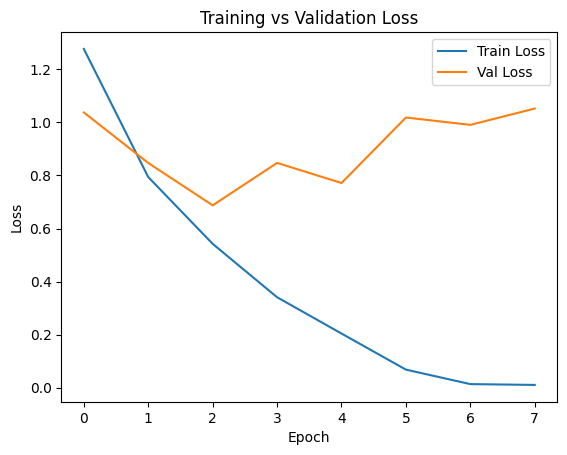

Model saved to: /content/puzzarm_model.pth


In [5]:
import zipfile
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

zip_path = "/content/Training Data.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

data_dir = "/content/dataset/Training Data"
print("Dataset extracted to:", data_dir)

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

full_dataset = datasets.ImageFolder(data_dir, transform=transform)

train_size = int(0.7 * len(full_dataset))
val_size   = int(0.2 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=4, shuffle=False)

class_names = full_dataset.classes
print("Classes:", class_names)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*32, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleCNN(num_classes=len(class_names)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 8
train_losses = []
val_losses   = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

save_path = "/content/puzzarm_model.pth"
torch.save(model.state_dict(), save_path)

print("Model saved to:", save_path)
